In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)


from unidecode import unidecode
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')
nltk.download('punkt')
from nltk import word_tokenize,sent_tokenize
from collections import Counter

[nltk_data] Downloading package stopwords to /home/sakce/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sakce/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
!pwd

/home/sakce/git/US-Debate-Tweets-Analysis/scripts_notebooks


In [3]:
df_initial_debate = pd.read_csv("../data/us_election_2020_2nd_presidential_debate.csv")

In [4]:
# df_initial_debate = pd.read_csv("us_election_2020_2nd_presidential_debate.csv")

# Making new dataframe which wont have repeating speakers that are the same person

speakers = []
minutes = []
texts = []

for index in range(len(df_initial_debate)-1):

    # debate attributes
    speaker = df_initial_debate.iloc[index].speaker
    minute = df_initial_debate.iloc[index].minute
    current_text = df_initial_debate.iloc[index].text
    next_speaker = df_initial_debate.iloc[index+1].speaker
    next_text = df_initial_debate.iloc[index+1].text

    try:
        # checking if the current speaker is the last speaker
        if speaker == df_initial_debate.iloc[index-1].speaker:
            # checking if the current speaker is also a next speaker
            if speaker == next_speaker:
                texts[-1] += " " + next_text
                continue # skipping to next iteration
            else:
                continue # skipping to next iteration
    
    except: # avoiding for the first row because there cant be previous speaker
            pass 
    
    if speaker == next_speaker: 
        #  combining the text of the current speaker and next if same
        speakers.append(speaker)
        minutes.append(minute)
        texts.append(current_text + " " + next_text)

    else:
        #  text only of current speaker given next one is different
        speakers.append(speaker)
        minutes.append(minute)
        texts.append(current_text)
        
debate_data = {"speaker":speakers,"minute":minutes,"text":texts}
df_debate = pd.DataFrame(debate_data)
df_debate['num_words'] = df_debate['text'].str.split().str.len()
df_debate['minute']=pd.to_datetime(df_debate['minute'], format='%M:%S')

df_debate_part1 = df_debate[0:73]
df_debate_part2 = df_debate[73:310]
df_debate_part3 = df_debate[310:]

In [5]:
df_debate_part1['time_between']=0
df_debate_part1['interrupted']=0
for i in range(0, 72):
    df_debate_part1['time_between'][i]=(df_debate_part1.iloc[i+1]['minute']-df_debate_part1.iloc[i]['minute']).total_seconds()
for i in range(0, 72):
    time = (df_debate_part1['time_between'][i]<=60 & df_debate_part1['time_between'][i+1]<=60)
    trump_biden = ((df_debate_part1['speaker'][i]=='Donald Trump') & (df_debate_part1['speaker'][i+1]=='Joe Biden'))
    biden_trump = ((df_debate_part1['speaker'][i]=='Joe Biden') & (df_debate_part1['speaker'][i+1]=='Donald Trump'))
    speakers = (trump_biden | biden_trump)
    if (time):
        df_debate_part1['interrupted'][i]=1
    if (time & speakers):
        df_debate_part1['interrupted'][i]=2
df_debate_part1['part']=1

In [6]:
df_debate_part2 = df_debate_part2.reset_index(drop=True)
df_debate_part2['time_between']=0
df_debate_part2['interrupted']=0
for i in range(0, 236):
    df_debate_part2['time_between'][i]=(df_debate_part2.iloc[i+1]['minute']-df_debate_part2.iloc[i]['minute']).total_seconds()
for i in range(0, 236):
    time = (df_debate_part2['time_between'][i]<=60 & df_debate_part2['time_between'][i+1]<=60)
    trump_biden = ((df_debate_part2['speaker'][i]=='Donald Trump') & (df_debate_part2['speaker'][i+1]=='Joe Biden'))
    biden_trump = ((df_debate_part2['speaker'][i]=='Joe Biden') & (df_debate_part2['speaker'][i+1]=='Donald Trump'))
    speakers = (trump_biden | biden_trump)
    if (time):
        df_debate_part2['interrupted'][i]=1
    if (time & speakers):
        df_debate_part2['interrupted'][i]=2
df_debate_part2['part']=2

In [7]:
df_debate_part3 = df_debate_part3.reset_index(drop=True)
df_debate_part3['time_between']=0
df_debate_part3['interrupted']=0
for i in range(0, 155):
    df_debate_part3['time_between'][i]=(df_debate_part3.iloc[i+1]['minute']-df_debate_part3.iloc[i]['minute']).total_seconds()
for i in range(0, 155):
    time = (df_debate_part3['time_between'][i]<=60 & df_debate_part3['time_between'][i+1]<=60)
    trump_biden = ((df_debate_part3['speaker'][i]=='Donald Trump') & (df_debate_part3['speaker'][i+1]=='Joe Biden'))
    biden_trump = ((df_debate_part3['speaker'][i]=='Joe Biden') & (df_debate_part3['speaker'][i+1]=='Donald Trump'))
    speakers = (trump_biden | biden_trump)
    if (time):
        df_debate_part3['interrupted'][i]=1
    if (time & speakers):
        df_debate_part3['interrupted'][i]=2
df_debate_part3['part']=3

In [8]:
df_debate_updated = pd.concat([df_debate_part1, df_debate_part2, df_debate_part3])
df_debate_updated = df_debate_updated.reset_index(drop=True)
df_debate_updated

,speaker,minute,text,num_words,time_between,interrupted,part
0,Kristen Welker,1900-01-01 00:00:18,"Good evening, everyone. Good evening. Thank yo...",258,439,0,1
1,Donald Trump,1900-01-01 00:07:37,How are you doing? How are you?,7,21,0,1
2,Kristen Welker,1900-01-01 00:07:58,And I do want to say a very good evening to bo...,222,66,0,1
3,Donald Trump,1900-01-01 00:09:04,"So as you know, 2.2 million people modeled out...",365,122,0,1
4,Kristen Welker,1900-01-01 00:11:06,Okay. Former Vice President Biden to you. How ...,22,7,1,1
...,...,...,...,...,...,...,...
461,Kristen Welker,1900-01-01 00:24:30,"All right. This is about leadership, gentlemen...",48,17,1,3
462,Donald Trump,1900-01-01 00:24:47,We have to make our country totally successful...,193,62,0,3
463,Kristen Welker,1900-01-01 00:25:49,"All right. Vice President Biden, same question...",25,8,1,3
464,Joe Biden,1900-01-01 00:25:57,"I will say, I’m an American President. I repre...",174,56,0,3


In [9]:
for i in range(0, len(df_debate_updated)):
    if (df_debate_updated['minute'][i].second>30):
        df_debate_updated['minute'][i]=df_debate_updated['minute'][i].minute + 1
    else:
        df_debate_updated['minute'][i]=df_debate_updated['minute'][i].minute

In [10]:
df_debate_interruptions = df_debate_updated[(df_debate_updated['interrupted']==2) | (df_debate_updated['interrupted']==1)]

In [11]:
df_interruption_minutes = df_debate_interruptions[['minute','part', 'interrupted']]

### If in a minute there is interruption score 1 and interruption score 2, we only keep 2

In [12]:
df_interruption_minutes = df_interruption_minutes.sort_values(by=['part', 'minute', 'interrupted'], ascending=False)
df_interruption_minutes = df_interruption_minutes.drop_duplicates(subset=['minute', 'part'])
df_interruption_minutes = df_interruption_minutes.sort_values(by=['part', 'minute'])
df_interruption_minutes

,minute,part,interrupted
4,11,1,1
8,13,1,1
10,14,1,1
14,15,1,1
16,16,1,1
...,...,...,...
419,21,3,2
424,22,3,1
431,23,3,2
442,24,3,2


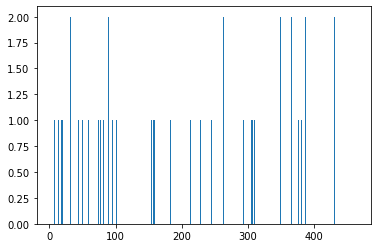

In [13]:
plt.bar(df_interruption_minutes.index, df_interruption_minutes['interrupted']);

## Making it connectable

In [14]:
df = df_interruption_minutes.reset_index(drop=True)

In [15]:
values = df.values.tolist()

In [16]:
def split_parts(value_list):
    
    parts = [[], [], []]

    def check_part(inner):
        return inner[1] - 1
        
    [parts[check_part(inner)].append(inner) for inner in value_list]
    
    return parts[0], parts[1], parts[2]

In [17]:
part1, part2, part3 = split_parts(values)

In [18]:
def add_missing(part):
    
    minutes = [inner[0] for inner in part]
    
    max_num = part[-1][0]
    part_num = part[-1][1]
    
    proper = [[i, part_num, 0] for i in range(0, max_num + 1)]
    
    for inner in part:
        proper[inner[0]][2] = inner[2]
    
    return proper

In [19]:
part1, part2, part3 = add_missing(part1), add_missing(part2), add_missing(part3)

In [20]:
fixed_parts = part1 + part2 + part3

In [21]:
for inner in fixed_parts:
    if inner[1] == 2:
        inner[0] += 30
    elif inner[1] == 3:
        inner[0] += 70

In [22]:
fixed_parts = part1 + part2 + part3

df = pd.DataFrame(fixed_parts, columns=['minute', 'part', 'interruption'])

In [23]:
df['timestamp'] = pd.Timestamp('2020-10-22 20:30')
df['timestamp'] = df.apply(lambda x: x['timestamp']
                           .replace(hour = x['timestamp'].hour + (x['timestamp'].minute + x['minute']) // 60,
                                    minute = (x['timestamp'].minute + x['minute']) % 60),
                           axis = 1)

In [24]:
!pwd

/home/sakce/git/US-Debate-Tweets-Analysis/scripts_notebooks


In [25]:
df.to_csv('../data/interruptions_per_minute_adjusted.csv', index = False)